# Περιγραφή Δεδομένων

Τα δεδομένα προέρχονται απο εκπομπές του συστήματος AIS, που αποτελεί μέσο αναγνώρισης πλοίων. Για την λήψη του χρησιμοποιήθηκε πηγή open source ενώ η περιοχή ενδιαφέροντος περιλαμβάνει την Μεσόγειο θάλασσα. Τα δεδομένα αντλήθηκαν στις 09-12-2023.

Αρχικά εισάγουμε τις βιβλιοθήκες εκείνες που θα μας βοηθήσουν στην ανάλυση των δεδομένων μας.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser as parser
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import hvplot.pandas
from holoviews import opts, dim
from geopandas import GeoDataFrame, read_file
from os.path import exists
from urllib.request import urlretrieve
import seaborn as sns
import plotly.express as px


Στη συνέχεια κάνουμε εισαγωγή και μετατρέπουμε το .csv αρχείο μας σε pandas dataframe.

In [2]:
# Read csv file as a dataframe
raw_ship_data = pd.read_csv('data.csv')
print(f"Finished reading {raw_ship_data.shape} lines of data")

Finished reading (1003, 16) lines of data


Παρατηρούμε πως τα δεδομένα μας είναι ενάς πίνακας 1003Χ16 κελιών. Με μία ενδεικτική επιστροφή των δεδομένων παρακάτω μπορούμε να δούμε πώς είναι διαμορφωμένα.

In [3]:
raw_ship_data.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID
0,2023-12-09 08:05:51.944186364 +0000 UTC,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,28,107,15,15,4.5,5
1,2023-12-09 08:05:54.203014122 +0000 UTC,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,7,21,2,7,2.4,5
2,2023-12-09 08:05:57.546130448 +0000 UTC,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,138,20,20,4,10.0,5
3,2023-12-09 08:06:05.451479994 +0000 UTC,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,18,32,5,5,2.4,5
4,2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,21,154,24,6,0.0,5


Αρχικά μας ενδιαφέρει να εντοπίσουμε τα είδη των δεδομένων στα οποία αναφέρεται κάθε στήλη, για τον λόγο αυτό επιστρέφουμε το όνομα κάθε στήλης.

In [4]:
# Rename the dataframe for processing reasons
geo_raw_ship_data = raw_ship_data
# Print the columns of our data
print(raw_ship_data.columns)

Index(['time_utc', 'CallSign', 'ShipName', 'Type', 'ImoNumber', 'MMSI',
       'latitude', 'longitude', 'Destination', 'FixType', 'Dimension A',
       'Dimension B', 'Dimension C', 'Dimension D', 'MaximumStaticDraught',
       'MessageID'],
      dtype='object')


Ανατρέχοντας στην διεύθυνση <a href="https://en.wikipedia.org/wiki/Automatic_identification_system" target="_blank">AIS-Wikipedia</a> μπορούμε να δούμε τι ακριβώς περιλαμβάνει κάθε στήλη.


Εξετάζοντας τα στοιχεία, επιθυμούμε να βρούμε κελιά του πίνακα στα οποία λείπουν δεδομένα.

In [5]:
# Print missing values
print("Any missing values:", geo_raw_ship_data.isnull().any().any())

# Count missing values
null_counts_total = geo_raw_ship_data.isnull().sum().sum()
print("null_counts_total:", null_counts_total)

Any missing values: True
null_counts_total: 81


In [6]:
# Rows with at least one null value:
geo_raw_ship_data[geo_raw_ship_data.isnull().any(axis=1)]

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID
4,2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,21,154,24,6,0.0,5
20,2023-12-09 08:07:43.529290641 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831317,34.639927,NaN,0,0,236,0,32,0.0,5
32,2023-12-09 08:08:52.471973589 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831242,34.639950,NaN,1,191,45,22,10,0.0,5
68,2023-12-09 08:12:54.22487949 +0000 UTC,P3CQ9,PETSAS I,0,0,209352000,34.664468,33.029690,NaN,15,0,0,0,0,0.0,5
77,2023-12-09 08:13:34.066695382 +0000 UTC,EAPC,EAPC CONTROL,0,0,428990000,31.642125,34.531130,NaN,1,0,0,0,0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,2023-12-09 09:33:59.397178623 +0000 UTC,XCAN5,ADMIRAL,31,0,345050010,34.673365,33.066440,NaN,0,8,30,6,4,0.0,5
958,2023-12-09 09:36:10.766430451 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652465,33.016780,NaN,1,21,154,24,6,0.0,5
967,2023-12-09 09:36:44.471522672 +0000 UTC,XCAN5,ADMIRAL,31,9421582,345050010,34.673347,33.066408,NaN,1,8,30,6,4,0.0,5
976,2023-12-09 09:37:31.104895846 +0000 UTC,EAPC,EAPC CONTROL,0,0,428990000,31.642107,34.531045,NaN,1,0,0,0,0,0.0,5


Παρατηρώντας πως έχουμε δεδομένα που λείπουν εξετάζουμε σε ποιές στήλες υφίσταται αυτό.

In [7]:
#  Print dataframe null values in each column
null_counts = geo_raw_ship_data.isnull().sum()
print("Null counts in each column:") 
print(null_counts)

Null counts in each column:
time_utc                 0
CallSign                17
ShipName                 0
Type                     0
ImoNumber                0
MMSI                     0
latitude                 0
longitude                0
Destination             64
FixType                  0
Dimension A              0
Dimension B              0
Dimension C              0
Dimension D              0
MaximumStaticDraught     0
MessageID                0
dtype: int64


Επομένως οι στήλες για τις οποίες δεν έχουμε δεδομένα είναι "callsign" και "destination". Με τον τρόπο αυτό αντιλαμβανόμαστε πως μπορούμε να προχωρήσουμε στην περαιτέρω επεξεργασία των δεδομένων. 

Ξεκινώντας απο τη στήλη του χρόνου αρχικά θα χρειαστεί να την αναγνωρίσουμε σαν timestamp και να διορθώσουμε την μορφή ώστε η ακρίβεια να σταματάει στα δευτερόλεπτα.

In [8]:
#Parse time column as timestamp and reshape time format
geo_raw_ship_data['time_utc'] = pd.to_datetime(geo_raw_ship_data['time_utc'], format='%Y-%m-%d %H:%M:%S.%f %z UTC')
geo_raw_ship_data['time_utc'] = geo_raw_ship_data['time_utc'].dt.strftime("%Y-%m-%d %H:%M:%S")
geo_raw_ship_data.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID
0,2023-12-09 08:05:51,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,28,107,15,15,4.5,5
1,2023-12-09 08:05:54,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,7,21,2,7,2.4,5
2,2023-12-09 08:05:57,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,138,20,20,4,10.0,5
3,2023-12-09 08:06:05,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,18,32,5,5,2.4,5
4,2023-12-09 08:06:08,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,21,154,24,6,0.0,5


Υπολογίζουμε τη χρονική διάρκεια των δεδομένων μας.

In [9]:
# Time delta
geo_raw_ship_data['time_utc'] = pd.to_datetime(geo_raw_ship_data['time_utc'])
last_index = len(geo_raw_ship_data) - 1
time_delta = geo_raw_ship_data.loc[last_index, 'time_utc'] - geo_raw_ship_data.loc[0, 'time_utc'] 
print(time_delta)

0 days 01:33:46


Στη συνέχεια θα μετατρέψουμε τις στήλες των συντεταγμένων σε μορφή τέτοια ώστε να είναι αξιοποιήσιμες για μετέπειτα απεικόνιση. Τα στοιχεία θα προστεθούν στο τέλος του πίνακα σαν στήλη με το όνομα "geometry".

In [10]:
# Coordinates format to point format for plotting and visualization
geo_raw_ship_data = gpd.GeoDataFrame(raw_ship_data, geometry=gpd.points_from_xy(raw_ship_data.longitude, raw_ship_data.latitude), crs="EPSG:4326")
geo_raw_ship_data.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID,geometry
0,2023-12-09 08:05:51,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,28,107,15,15,4.5,5,POINT (33.05835 34.66968)
1,2023-12-09 08:05:54,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,7,21,2,7,2.4,5,POINT (33.00969 34.64540)
2,2023-12-09 08:05:57,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,138,20,20,4,10.0,5,POINT (29.00512 35.82620)
3,2023-12-09 08:06:05,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,18,32,5,5,2.4,5,POINT (33.00900 34.64513)
4,2023-12-09 08:06:08,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,21,154,24,6,0.0,5,POINT (33.01678 34.65245)


Επίσης θα προχωρήσουμε στην σύμπτυξη των στηλών που αναφέρονται στις διαστάσεις. Η παρακάτω εικόνα μας βοηθάει στο να κατανοήσουμε τον τρόπο με τον οποίο πρέπει να δουλέψουμε.

<img src="https://downloads.intercomcdn.com/i/o/231836738/65f938bcdca4618f076528ba/AIS_Shipboard_AIS_User_Manual_manual_L-3_Communications.gif?expires=1620129848&signature=990df0a70d131141035cdc7a3699a27029e7bc4b23f9fb51616ccef6c219a446" />

In [11]:
# Collapsing dimension columns
geo_raw_ship_data['length'] = (geo_raw_ship_data['Dimension A'] + geo_raw_ship_data['Dimension B'])
geo_raw_ship_data['width'] = (geo_raw_ship_data['Dimension C'] + geo_raw_ship_data['Dimension D'])
geo_raw_ship_data = geo_raw_ship_data.drop(columns=['Dimension A', 'Dimension B', 'Dimension C', 'Dimension D'])
geo_raw_ship_data.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,MaximumStaticDraught,MessageID,geometry,length,width
0,2023-12-09 08:05:51,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,4.5,5,POINT (33.05835 34.66968),135,30
1,2023-12-09 08:05:54,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,2.4,5,POINT (33.00969 34.64540),28,9
2,2023-12-09 08:05:57,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,10.0,5,POINT (29.00512 35.82620),158,24
3,2023-12-09 08:06:05,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,2.4,5,POINT (33.00900 34.64513),50,10
4,2023-12-09 08:06:08,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,0.0,5,POINT (33.01678 34.65245),175,30


Μετά τη σύμπτυξη  επιθυμούμε να εστιάσουμε στα δεδομένα αυτών των στηλών. Επομένως εντοπίζουμε αρχικά τις διαστάσεις με τιμή 0 και την κατηγορία του σκάφους που αυτή η συνθήκη ισχύει.

In [12]:
# Find the vessels with "0" values in their dimensions
length_dimension = geo_raw_ship_data[(geo_raw_ship_data['length']==0)]
width_dimension = geo_raw_ship_data[(geo_raw_ship_data['width']==0)]
# Ship Types with 0 in length
print(length_dimension['Type'].unique())
# Ship Types with 0 in width
print(width_dimension['Type'].unique())

[70 52  0]
[70 52  0]


Επομένως οι κατηγορίες στις οποίες εντοπίζουμε τιμές 0 στις διαστάσεις είναι [ 70 = cargo, 52 = Tug, 0 = default ]

Επομένως για καλύτερη διαχείριση των δεδομένων μας θα προχωρήσουμε στην αντικατάστασή τους με την μέση τιμή των υπόλοιπων εγγραφών της κατηγορίας. 

In [13]:
# Get all the ships that are of type cargo, tug, default
cargo = geo_raw_ship_data[(geo_raw_ship_data['Type'] == 70)]
tug = geo_raw_ship_data[(geo_raw_ship_data['Type'] == 52)]
default = geo_raw_ship_data[(geo_raw_ship_data['Type'] == 0)]

In [14]:
# Calculate the mean value of their dimensions
cargo_mean_length = int(cargo['length'].mean())
cargo_mean_width = int(cargo['width'].mean())

tug_mean_length = int(tug['length'].mean())
tug_mean_width = int(tug['width'].mean())

default_mean_length = int(default['length'].mean())
default_mean_width = int(default['width'].mean())

In [15]:
# Replace the zero values with the mean value
geo_raw_ship_data.loc[(geo_raw_ship_data['length'] == 0) & (geo_raw_ship_data['Type']==70), ['length']] = cargo_mean_length
geo_raw_ship_data.loc[(geo_raw_ship_data['width'] == 0) & (geo_raw_ship_data['Type']==70), ['width']] = cargo_mean_width

geo_raw_ship_data.loc[(geo_raw_ship_data['length'] == 0) & (geo_raw_ship_data['Type']==52), ['length']] = tug_mean_length
geo_raw_ship_data.loc[(geo_raw_ship_data['width'] == 0) & (geo_raw_ship_data['Type']==52), ['width']] = tug_mean_width

geo_raw_ship_data.loc[(geo_raw_ship_data['length'] == 0) & (geo_raw_ship_data['Type']==0), ['length']] = default_mean_length
geo_raw_ship_data.loc[(geo_raw_ship_data['length'] == 0) & (geo_raw_ship_data['Type']==0), ['width']] = tug_mean_width

Μετά την επεξεργασία των δεδομένων μας η νέα μορφή του είναι η εξής

In [16]:
# Get the shape of our dataframe
geo_raw_ship_data.shape

(1003, 15)

In [17]:
geo_raw_ship_data.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,MaximumStaticDraught,MessageID,geometry,length,width
0,2023-12-09 08:05:51,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,4.5,5,POINT (33.05835 34.66968),135,30
1,2023-12-09 08:05:54,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,2.4,5,POINT (33.00969 34.64540),28,9
2,2023-12-09 08:05:57,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,10.0,5,POINT (29.00512 35.82620),158,24
3,2023-12-09 08:06:05,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,2.4,5,POINT (33.00900 34.64513),50,10
4,2023-12-09 08:06:08,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,0.0,5,POINT (33.01678 34.65245),175,30


## Διαγράμματα

Όπως αναφέραμε παραπάνω τα δεδομένα αποτελούνται απο χρονικά διακριτές εκπομπές πλοίων διάρκειας 01:33:00. Για να εξετάσουμε ποιοτικά τις εγγραφές θα απομονώσουμε τα πλοία σαν οντότητες σε έναν νέο dataframe.

In [18]:
# Dataframe unique values overview
geo_raw_ship_data.nunique()

time_utc                909
CallSign                 91
ShipName                 91
Type                     24
ImoNumber                76
MMSI                     92
latitude                752
longitude               742
Destination              44
FixType                   5
MaximumStaticDraught     49
MessageID                 1
geometry                886
length                   67
width                    27
dtype: int64

Επιστρέφοντας τις μοναδικές τιμές καταλήγουμε στο συμπέρασμα πως έχουμε 92 μοναδικά πλοία με αναφορά τον μοναδικό αριθμό MMSI. Παρακάτω επιστρέφουμε τον κωδικό MMSI καθενός απο αυτά.

In [19]:
# Find the number of unique ships inside of our table using as key the MMSI since it has no 0 values and it is an ID attribute
print(np.sort(geo_raw_ship_data['MMSI'].unique()))

[  4282000 209005000 209166000 209343000 209352000 209492000 209511000
 209969000 210282000 210330000 210588000 210595000 211920000 212212000
 212230000 212319000 212541000 212717000 212858000 212872000 215013000
 215209000 229447000 233303000 235090927 236723000 241776000 244810178
 247274900 248823000 255806109 255977000 255979000 256060000 256081000
 256251000 257073920 271044343 271047045 271051041 271052043 305299000
 305384000 311000706 312349000 319222400 319234300 319287000 345050010
 352002159 352002364 352002749 353822000 371343000 375369000 428000112
 428000407 428007000 428009070 428045000 428066000 428068000 428990000
 470763000 511100389 511100460 511100504 511100835 518998397 538002973
 538003685 538007432 538009102 538009176 563112000 572705210 577171000
 613226010 613871403 622113180 630001049 636014902 636015074 636019201
 636021330 636021691 636022888 667001448 667001603 668116210 671290100
 987170323]


Δημιουργούμε ένα νέο dataframe που θα περιλαμβάνει μόνο τα πλοία.

In [20]:
# Get a dataframe with only the single ships
unique_ships = geo_raw_ship_data.drop_duplicates(subset=['MMSI'])
display(unique_ships)

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,MaximumStaticDraught,MessageID,geometry,length,width
0,2023-12-09 08:05:51,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,4.5,5,POINT (33.05835 34.66968),135,30
1,2023-12-09 08:05:54,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,2.4,5,POINT (33.00969 34.64540),28,9
2,2023-12-09 08:05:57,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,10.0,5,POINT (29.00512 35.82620),158,24
3,2023-12-09 08:06:05,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,2.4,5,POINT (33.00900 34.64513),50,10
4,2023-12-09 08:06:08,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,0.0,5,POINT (33.01678 34.65245),175,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,2023-12-09 09:09:12,V7SN2,DANCHOR IX,99,9316787,538003685,32.814877,35.030665,NaN,1,2.1,5,POINT (35.03066 32.81488),59,9
664,2023-12-09 09:09:29,3E3832,NOVA CORALIA,70,8918409,352002159,32.818160,35.016760,IL HFA,1,7.1,5,POINT (35.01676 32.81816),119,18
668,2023-12-09 09:09:38,5BWY5,LEDRA EXPLORER,52,0,210330000,34.541397,33.239995,LIMASSOL CYPRUS,0,3.0,5,POINT (33.24000 34.54140),39,9
839,2023-12-09 09:25:02,V7A4413,STELLAR LADY,70,9574004,538009176,30.142940,32.569717,CANAKKALE,1,6.3,5,POINT (32.56972 30.14294),183,32


Επεξεργαζόμαστε το νέο πίνακα με κριτήριο τον τύπο των πλοίων.

In [21]:
# Find the different type of ships
ship_type = unique_ships['Type'].unique()
print(np.sort(ship_type))

[ 0 31 33 34 35 37 40 50 51 52 59 60 68 69 70 71 79 80 82 89 90 91 92 99]


Κάθε τύπος πλοίου περιγράφεται παρακάτω.

<style>
Shipso { border:1px solid #C0C0C0; border-collapse:collapse; padding:5px; }
Shipsmo th { border:1px solid #C0C0C0; padding:5px; background:#F0F0F0;}Shipsemo td { border:1px solid #C0C0C0; padding:5px;}
</style>

<table class="Ships">
<thead>
    <tr>
        <th>Type</th>
        <th>Description</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>0</td>
        <td>default</td>
    </tr>
    <tr>
        <td>31</td>
        <td>Towing</td>
    </tr>
    <tr>
        <td>33</td>
        <td>Dredging</td>
    </tr>
    <tr>
        <td>34</td>
        <td>Diving</td>
    </tr>
    <tr>
        <td>35</td>
        <td>Military</td>
    </tr>
    <tr>
        <td>37</td>
        <td>Pleasure</td>
    </tr>
    <tr>
        <td>40</td>
        <td>HighSpeedCraft (HSC)</td>
    </tr>
    <tr>
        <td>50</td>
        <td>Pilot</td>
    </tr>
    <tr>
        <td>51</td>
        <td>SAR</td>
    </tr>
    <tr>
        <td>52</td>
        <td>Tug</td>
    </tr>
    <tr>
        <td>59</td>
        <td>Noncombatant</td>
    </tr>
    <tr>
        <td>60</td>
        <td>Passenger</td>
    </tr>
    <tr>
        <td>68</td>
        <td>Passenger Reserved for future us</td>
    </tr>
    <tr>
        <td>69</td>
        <td>Passenger No additional information</td>
    </tr>
    <tr>
        <td>70</td>
        <td>Cargo all ships of this type</td>
    </tr>
    <tr>
        <td>71</td>
        <td>Cargo Hazardous category A</td>
    </tr>
    <tr>
        <td>79</td>
        <td>Cargo No additional information</td>
    </tr>
    <tr>
        <td>80</td>
        <td>Tanker all ships of this type</td>
    </tr>
    <tr>
        <td>82</td>
        <td>Tanker Hazardous category B</td>
    </tr>
    <tr>
        <td>89</td>
        <td>Tanker No additional information</td>
    </tr>
    <tr>
        <td>90</td>
        <td>Other Type all ships of this type</td>
    </tr>
    <tr>
        <td>91</td>
        <td>Other Type Hazardous category A</td>
    </tr>
    <tr>
        <td>92</td>
        <td>Other Type Hazardous category B</td>
    </tr>
    <tr>
        <td>99</td>
        <td>Other Type no additional information</td>
    </tr>
    </tbody>
</table>

Εάν παρατηρήσουμε καλύτερα τις κατηγορίες συμπεράινουμε πως μπορούμε να τις εντάξουμε σε πιο γενικές. Πιο ειδικά για τις κατηγορίες 60, 70, 80, 90. 

In [22]:
# Collapse vessel subcategories to categories
unique_ships.loc[(unique_ships['Type'] == 71) | (unique_ships['Type'] == 79), 'Type'] = 70

In [23]:
unique_ships.loc[(unique_ships['Type'] == 68) | (unique_ships['Type'] == 69), 'Type'] = 60

In [24]:
unique_ships.loc[(unique_ships['Type'] == 82) | (unique_ships['Type'] == 89), 'Type'] = 80

In [25]:
unique_ships.loc[(unique_ships['Type'] == 91) | (unique_ships['Type'] == 92) | (unique_ships['Type'] == 99), 'Type'] = 90

In [26]:
unique_ships.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,MaximumStaticDraught,MessageID,geometry,length,width
0,2023-12-09 08:05:51,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,4.5,5,POINT (33.05835 34.66968),135,30
1,2023-12-09 08:05:54,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,2.4,5,POINT (33.00969 34.64540),28,9
2,2023-12-09 08:05:57,TCA5645,KOSOVAK,70,9211157,271047045,35.826203,29.005122,TRALI,1,10.0,5,POINT (29.00512 35.82620),158,24
3,2023-12-09 08:06:05,5BFB3,EDT LEON,90,9575400,209343000,34.645127,33.008998,LIMASSOL,0,2.4,5,POINT (33.00900 34.64513),50,10
4,2023-12-09 08:06:08,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,0.0,5,POINT (33.01678 34.65245),175,30


Εφόσον έχουμε πλεόν έναν πίνακα μόνο με τα πλοία μπορούμε να απεικονίσουμε ορισμένα διαγράμματα.

Αρχικά απεικονίζουμε το πλήθος των πλοίων ανα κατηγορία.

In [27]:
# Proportion of each vessel category in our dataset
type_proportion = unique_ships['Type'].value_counts(normalize=True)

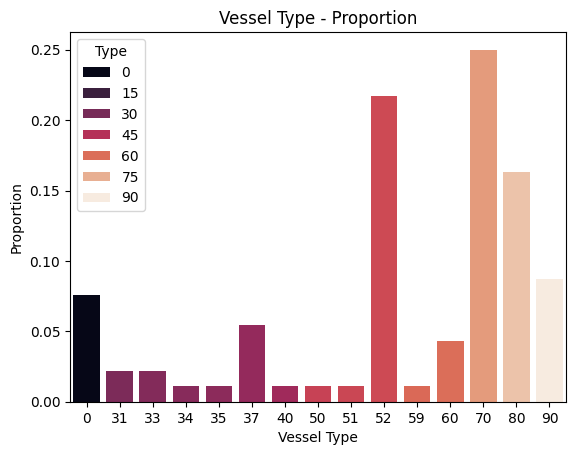

In [28]:
sns.barplot(x=type_proportion.index, y=type_proportion.values, hue=type_proportion.index, palette='rocket')
plt.title('Vessel Type - Proportion')
plt.xlabel('Vessel Type')
plt.ylabel('Proportion')

# Display the plot
plt.show()

Στη συνέχεια μας ενδιαφέρει να δούμε την κατηγορία του πομπού εκπομπής που χρησιμοποιεί κάθε σκάφος.

In [29]:
# Find the different fix types provided
fix_type = geo_raw_ship_data['FixType'].unique()
print(fix_type)

[ 1  0 15  6  3]


<style>
.Fix { border:1px solid #C0C0C0; border-collapse:collapse; padding:5px; }
.Fix th { border:1px solid #C0C0C0; padding:5px; background:#F0F0F0;}
.Fix td { border:1px solid #C0C0C0; padding:5px;}
</style>

<table class="Fix">
<thead>
    <tr>
        <th>FixType</th>
        <th>Description</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>0</td>
        <td>default</td>
    </tr>
    <tr>
        <td>1</td>
        <td>GPS</td>
    </tr>
    <tr>
        <td>3</td>
        <td>GPS + GLONASS</td>
    </tr>
    <tr>
        <td>6</td>
        <td>INS</td>
    </tr>
    <tr>
        <td>15</td>
        <td>internal GNSS</td>
    </tr>       
    </tbody>
</table>INS
15 = internal GNSS


In [30]:
# Proportion of each vessel category in our dataset
fixType_proportion = unique_ships['FixType'].value_counts(normalize=True)

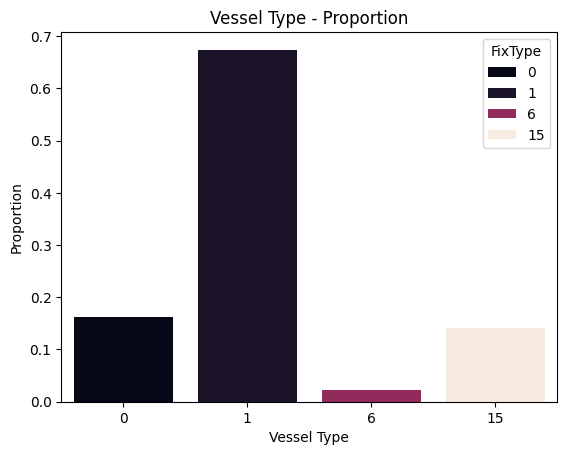

In [31]:
sns.barplot(x=fixType_proportion.index, y=fixType_proportion.values, hue=fixType_proportion.index, palette='rocket')
plt.title('Vessel Type - Proportion')
plt.xlabel('Vessel Type')
plt.ylabel('Proportion')

# Display the plot
plt.show()

Για καλύτερη κατανόηση των δεδομένων μας θα δημιουργήσουμε ένα διαδραστικό διάγραμμα διασποράς που απεικονίζει στοιχεία σχετικά με το μέγεθος των πλοίων.

In [32]:
fig = px.scatter(unique_ships, x='length', y='width', color='Type', hover_data=['Type', 'MMSI', 'ShipName'])

# Customize the plot layout
fig.update_layout(title='Interactive Scatter Plot of Vessel Dimensions',
                  xaxis_title='Length',
                  yaxis_title='Width')

# Display the interactive plot
fig.show()

Επίσης απεικονίζουμε σε επόμενο διάγραμμα το εύρος που κυμάινεται το βύθισμα των σκαφών.

Text(0, 0.5, 'Draught')

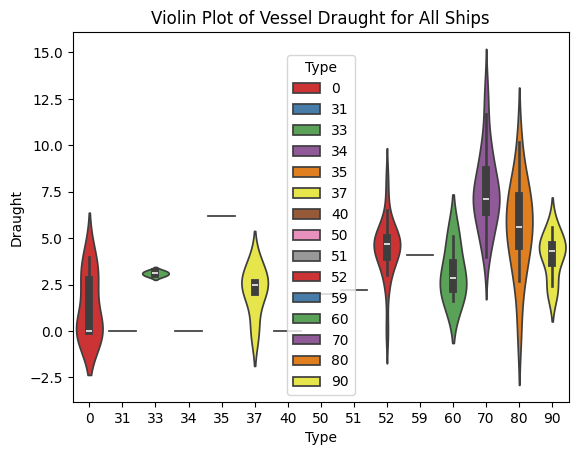

In [33]:
sns.violinplot(x='Type',y='MaximumStaticDraught', data=unique_ships,hue='Type', palette='Set1')
plt.title('Violin Plot of Vessel Draught for All Ships')
plt.ylabel('Draught')

Επιπρόσθετα, έχοντας ώς στόχο να αντλήσουμε τις περισσότερες πληροφορίες που μπορούμε απο τα δεδομένα αυτά, παρατηρούμε την ύπαρξη της στήλης (IMO_number).
Η στήλη IMO ή αλλίως International Maritime Organization Ship ID Number, αποτελεί μοναδικό κωδικό που ανατίθεται σε κάθε πλοίο. 
Αυτός ο αριθμός χρησιμοποιείται για την ταυτοποίηση και το παρακολούθηση των πλοίων σε διεθνές επίπεδο.


Είτε πρόκειται για ένα μεγάλο φορτηγό πλοίο, ένα επιβατικό, ένα δεξαμενόπλοιο, 
είτε για ένα μικρότερο σκάφος, η ύπαρξη ενός μοναδικού αναγνωριστικού αριθμού συμβάλλει 
στην παρακολούθηση και διαχείριση των θαλάσσιων δραστηριοτήτων.

In [34]:
# variables for ships with or without IMO number 

# Get Ships with IMO number
Ships_with_IMO_number = geo_raw_ship_data[raw_ship_data["ImoNumber"] != 0]
Total_number_Ships_with_IMO = (geo_raw_ship_data["ImoNumber"] != 0).sum()

# Get Ships without IMO number
Ships_with_no_IMO_number = geo_raw_ship_data[geo_raw_ship_data["ImoNumber"] == 0]
Total_number_Ships_with_no_IMO = (geo_raw_ship_data["ImoNumber"] == 0).sum()

Αρχικά θα υπολογίσουμε το ποσοστό των πλοίων που δεν έχουν IMO αριθμό.

In [35]:
# Get percentage of ships without IMO number
Percentage_of_no_IMO_Ships = (
    Total_number_Ships_with_no_IMO 
    /geo_raw_ship_data["ImoNumber"].count()) * 100
round(Percentage_of_no_IMO_Ships)

24

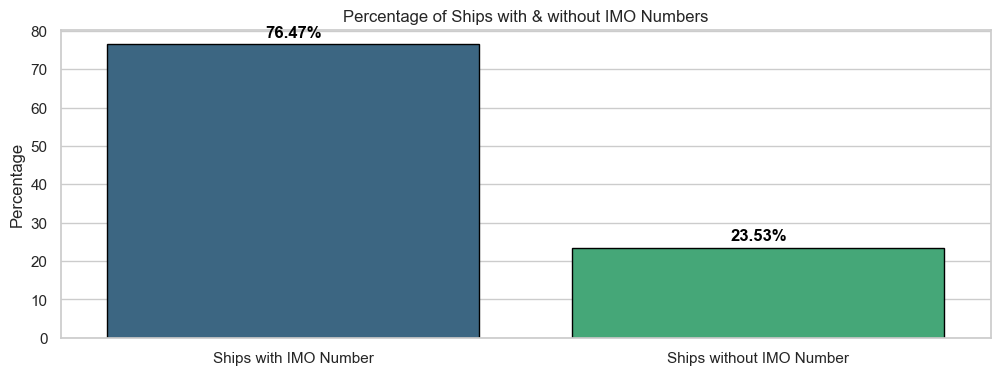

In [36]:
# Using bar chart to visualize the percentage difference.
sns.set(style="whitegrid")
plt.figure(figsize=(12, 4))
colors = sns.color_palette("viridis", n_colors=2)
sns.barplot(
x=['Ships with IMO Number', 'Ships without IMO Number'], 
y=[100 - Percentage_of_no_IMO_Ships, Percentage_of_no_IMO_Ships], 
palette=colors, 
edgecolor='black', 
hue=['Ships with IMO', 'Ships without IMO'], 
legend=False
)

plt.ylabel('Percentage')
plt.title('Percentage of Ships with & without IMO Numbers')

# Adding some text for more informative visualization (titles and % of each bar).
for i, value in enumerate([100 - Percentage_of_no_IMO_Ships, Percentage_of_no_IMO_Ships]):
    plt.text(
    i, value + 1, 
    f'{value:.2f}%', 
    ha='center', 
    va='bottom', 
    color='black', 
    fontweight='bold'
    )
# Display the plot
plt.show()


Όπως φαίνεται και απο το διάγραμμα το 24% του συνολικού αριθμού των πλοίων δεν διαθέτουν IMO αριθμό.


## Χάρτες

Επανερχόμαστε στο αρχικό dataframe. Αναζητούμε το πλοίο με τις περισσότερες εγγραφές επομένως και με τα περισσότερα δεδομένα συντεταγμένων.

In [37]:
# Find the ship with the most data
geo_raw_ship_data['ShipName'].value_counts()

ShipName
DEBBIE            27
SYMPHONY          18
IRIS              17
ASHDOD PORT       17
EDT LEON          17
                  ..
ELAD               1
VTS KERYNEIA       1
ADA 74             1
AKRITAS            1
SUSAN BORCHARD     1
Name: count, Length: 91, dtype: int64

Για ευκολία απομονώνουμε τον πίνακα σε έναν μικρότερο με τις στήλες που μας ενδιαφέρουν.

In [38]:
# Return a dataframe with only the data we need in order to plot trajectories
ship_data = geo_raw_ship_data[['time_utc','ShipName','MMSI','geometry']]
ship_data.head()

,time_utc,ShipName,MMSI,geometry
0,2023-12-09 08:05:51,SEMINOLE,247274900,POINT (33.05835 34.66968)
1,2023-12-09 08:05:54,EDT ZENON,212541000,POINT (33.00969 34.64540)
2,2023-12-09 08:05:57,KOSOVAK,271047045,POINT (29.00512 35.82620)
3,2023-12-09 08:06:05,EDT LEON,209343000,POINT (33.00900 34.64513)
4,2023-12-09 08:06:08,NAVAL AUXILIARY A135,233303000,POINT (33.01678 34.65245)


Παρατηρήσαμε πως το σκάφος με όνομα "DEBBIE" έχει τις περισσότερες εγγραφές, επομένως θα δώσουμε ιδιαίτερη έμφαση.

In [39]:
# Get vessel "Debbie" wich has the most records
ship_name_value="DEBBIE"
results = ship_data[ship_data["ShipName"] == ship_name_value]
print(results.head())

               time_utc ShipName       MMSI                   geometry
35  2023-12-09 08:09:28   DEBBIE  667001448  POINT (34.64196 31.82850)
45  2023-12-09 08:10:41   DEBBIE  667001448  POINT (34.64197 31.82847)
69  2023-12-09 08:12:56   DEBBIE  667001448  POINT (34.64197 31.82847)
127 2023-12-09 08:18:30   DEBBIE  667001448  POINT (34.64190 31.82863)
163 2023-12-09 08:22:48   DEBBIE  667001448  POINT (34.64196 31.82861)


Μετατρέπουμε τα δεδομένα συντεταγμένων σε τροχιές.

In [40]:
traj_collection = mpd.TrajectoryCollection(results, 'MMSI', t='time_utc', min_length=5)
traj_collection = mpd.MinTimeDeltaGeneralizer(traj_collection).generalize(tolerance=timedelta(seconds=30))
print(traj_collection)

TrajectoryCollection with 1 trajectories


c:\Users\George\AppData\Local\Programs\Python\Python311\Lib\site-packages\movingpandas\trajectory_generalizer.py:115: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [41]:
my_traj = traj_collection.trajectories[0]
print(my_traj)

Trajectory 667001448 (2023-12-09 08:09:28 to 2023-12-09 09:35:15) | Size: 27 | Length: 139.5m
Bounds: (34.64185, 31.828466666666667, 34.642015, 31.82865)
LINESTRING (34.64196166666667 31.828498333333336, 34.64196666666667 31.828466666666667, 34.641966666


In [42]:
my_traj.hvplot(title='Ship DEBBIE', frame_width=700, frame_height=500, line_width=5.0, cmap='Dark2') 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

Ως επέκταση του προηγούμενου ερωτήματος που θέσαμε σχετικά με το ποσοστό των πλοίων που δεν διαθέτουν IMO αριθμό θα προβούμε στην κατασκευή ενός γραφήματος διασποράς.


Το γράφημα θα περιέχει ως dataframe μονο τα πλοία εκείνα που δεν έχουν αριθμό IMO με σκοπό την οπτικοποίηση τους σε χάρτη, βάσει του γεωγραφικού μήκους και πλάτους.

Ένα ακόμη γνώρισμα που θα έχουν θα είναι ο τύπος του κάθε πλοίου.
Υπενθυμίζοντας ότι:

<style>
Shipso { border:1px solid #C0C0C0; border-collapse:collapse; padding:5px; }
Shipsmo th { border:1px solid #C0C0C0; padding:5px; background:#F0F0F0;}Shipsemo td { border:1px solid #C0C0C0; padding:5px;}
</style>

<table class="Ships">
<thead>
    <tr>
        <th>Type</th>
        <th>Description</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>0</td>
        <td>default</td>
    </tr>
    <tr>
        <td>31</td>
        <td>Towing</td>
    </tr>
    <tr>
        <td>33</td>
        <td>Dredging</td>
    </tr>
    <tr>
        <td>34</td>
        <td>Diving</td>
    </tr>
    <tr>
        <td>35</td>
        <td>Military</td>
    </tr>
    <tr>
        <td>37</td>
        <td>Pleasure</td>
    </tr>
    <tr>
        <td>40</td>
        <td>HighSpeedCraft (HSC)</td>
    </tr>
    <tr>
        <td>50</td>
        <td>Pilot</td>
    </tr>
    <tr>
        <td>51</td>
        <td>SAR</td>
    </tr>
    <tr>
        <td>52</td>
        <td>Tug</td>
    </tr>
    <tr>
        <td>59</td>
        <td>Noncombatant</td>
    </tr>
    <tr>
        <td>60</td>
        <td>Passenger</td>
    </tr>
    <tr>
        <td>68</td>
        <td>Passenger Reserved for future us</td>
    </tr>
    <tr>
        <td>69</td>
        <td>Passenger No additional information</td>
    </tr>
    <tr>
        <td>70</td>
        <td>Cargo all ships of this type</td>
    </tr>
    <tr>
        <td>71</td>
        <td>Cargo Hazardous category A</td>
    </tr>
    <tr>
        <td>79</td>
        <td>Cargo No additional information</td>
    </tr>
    <tr>
        <td>80</td>
        <td>Tanker all ships of this type</td>
    </tr>
    <tr>
        <td>82</td>
        <td>Tanker Hazardous category B</td>
    </tr>
    <tr>
        <td>89</td>
        <td>Tanker No additional information</td>
    </tr>
    <tr>
        <td>90</td>
        <td>Other Type all ships of this type</td>
    </tr>
    <tr>
        <td>91</td>
        <td>Other Type Hazardous category A</td>
    </tr>
    <tr>
        <td>92</td>
        <td>Other Type Hazardous category B</td>
    </tr>
    <tr>
        <td>99</td>
        <td>Other Type no additional information</td>
    </tr>
    </tbody>
</table>

In [44]:
# Reminder of variable ships_without_imo
ships_without_imo = geo_raw_ship_data[geo_raw_ship_data['ImoNumber'].isnull()]

# Choosing the column that need the colour differentiation
cat_column_ShipType = 'Type'

# Create a GeoDataFrame for ships without IMO numbers
geometry = [Point(xy) for xy in zip(Ships_with_no_IMO_number['longitude'], Ships_with_no_IMO_number['latitude'])]
geo_Ships_with_no_IMO_number = gpd.GeoDataFrame(Ships_with_no_IMO_number, geometry=geometry)

In [45]:
# Create a Plotly Express scatter plot with a larger map
fig = px.scatter_geo(
geo_Ships_with_no_IMO_number,
lat='latitude', lon='longitude',
color=cat_column_ShipType,
title='World map to visualize ships with no IMO numbers giving lattitude, longitude and different colors for each ship type',
width=1800,  
height=1000,  
)
# Display the plot
fig.show()